<a href="https://colab.research.google.com/github/Rajatsaxenabhu/Neural-Style-Transfer/blob/main/Neureal_Style_Transfer_Mini_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
network = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

In [ ]:
content_image='/content/Main.jpg'            #place the content image
style_image='/content/Adstract.webp'         #place the artistic or style image.


In [ ]:
def process(image):
    height, width = image.shape[:2]
    target_width = 1920
    target_height = 1080

    # Determine the orientation of the image
    if height > width:  # Portrait orientation
        ratio = target_height / height
    else:  # Landscape orientation
        ratio = target_width / width

    # Resize the image while maintaining the aspect ratio
    resized_image = cv2.resize(image, (int(width * ratio), int(height * ratio)))

    return resized_image

In [ ]:
import cv2
import pandas as pd
content_image = cv2.imread(content_image)
content_image=process(content_image)
content_image_1 = cv2.cvtColor(content_image , cv2.COLOR_BGR2RGB)
content_image = cv2.cvtColor(content_image , cv2.COLOR_BGR2GRAY)

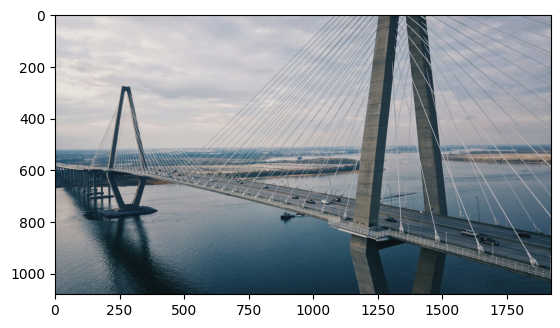

In [ ]:
plt.imshow(content_image_1)
plt.show()

In [ ]:
type(content_image), content_image.shape, content_image.min(), content_image.max()

(numpy.ndarray, (1080, 1920, 3), 9, 236)

In [ ]:
content_image = content_image / 255
content_image.min(), content_image.max()

(0.03529411764705882, 0.9254901960784314)

In [ ]:
content_image = content_image[tf.newaxis, :]
content_image.shape

(1, 1080, 1920, 3)

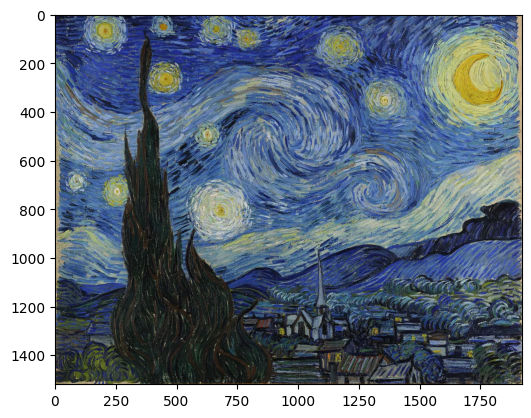

In [ ]:
style_image = cv2.imread(style_image)
style_image=process(style_image)
style_image= cv2.cvtColor(style_image, cv2.COLOR_BGR2RGB)
plt.imshow(style_image)
plt.show()

In [ ]:
style_image = style_image / 255
style_image = style_image[tf.newaxis, :]


In [ ]:
content_layers = ['block4_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

In [ ]:
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)
print(num_content_layers, num_style_layers)

1 5


In [ ]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]
    network = tf.keras.Model(inputs = [vgg.input], outputs = outputs)

    return network

In [ ]:
style_extractor = vgg_layers(style_layers)
style_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
style_outputs = style_extractor(style_image)
len(style_outputs)

5

In [ ]:
style_outputs[0].shape, style_outputs[1].shape, style_outputs[2].shape, style_outputs[3].shape, style_outputs[4].shape

(TensorShape([1, 1520, 1920, 64]),
 TensorShape([1, 760, 960, 128]),
 TensorShape([1, 380, 480, 256]),
 TensorShape([1, 190, 240, 512]),
 TensorShape([1, 95, 120, 512]))

In [ ]:
def gram_matrix(layer_activation):
    result = tf.linalg.einsum('bijc,bijd->bcd', layer_activation, layer_activation)
    input_shape = tf.shape(layer_activation)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)

    return result / num_locations

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super().__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    inputs = inputs * 255.0
    # 0 - 1
    # -127.50 - 127.50
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs = outputs[:self.num_style_layers]
    content_outputs = outputs[self.num_style_layers:]

    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

    content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
    style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

In [ ]:
results = extractor(content_image)
# results

In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [ ]:
new_image = tf.Variable(content_image)

In [ ]:
content_weight = 1
style_weight = 100

In [ ]:
optimizer = tf.optimizers.Adam(learning_rate=0.01, beta_1=0.99, epsilon=1e-1)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


Epoch 250 | content loss: 302203.6875 | style loss: 142516384.0 | total loss 2850629888.0


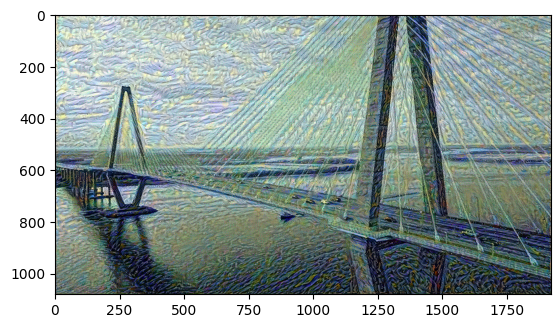

Epoch 500 | content loss: 311769.34375 | style loss: 31379954.0 | total loss 627910848.0


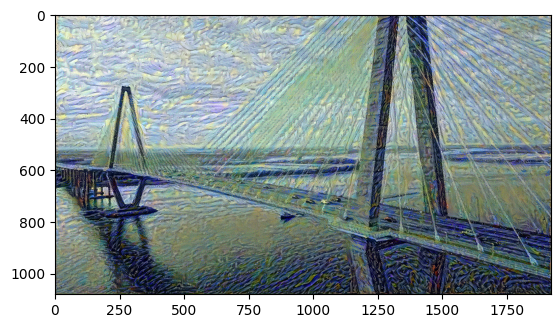

Epoch 750 | content loss: 314845.15625 | style loss: 15512170.0 | total loss 310558240.0


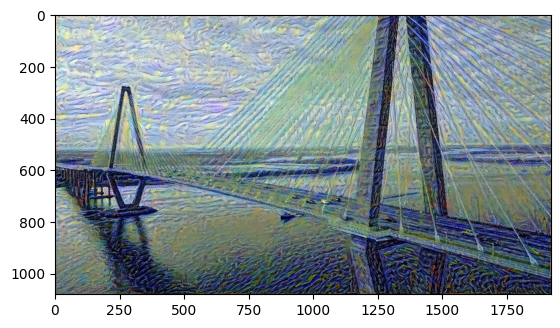

Epoch 1000 | content loss: 316304.8125 | style loss: 10361746.0 | total loss 207551216.0


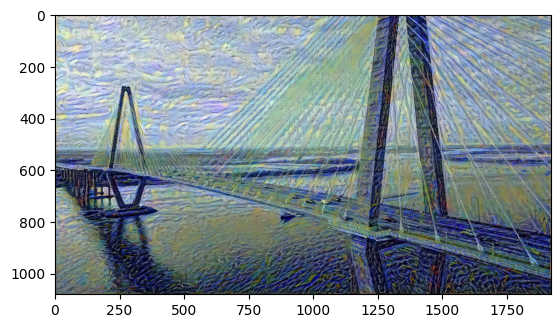

In [ ]:
epochs = 1000
print_every =250

for epoch in range(epochs):
  with tf.GradientTape() as tape:
    outputs = extractor(new_image)
    content_outputs = outputs['content']
    style_outputs = outputs['style']

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2) for name in content_outputs.keys()])
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2) for name in style_outputs.keys()])

    total_loss = content_loss * content_weight / num_content_layers + style_loss * style_weight / num_style_layers

  gradient = tape.gradient(total_loss, new_image)
  optimizer.apply_gradients([(gradient, new_image)])

  new_image.assign(tf.clip_by_value(new_image, 0.0, 1.0))

  if (epoch + 1) % print_every == 0:
    print('Epoch {} | content loss: {} | style loss: {} | total loss {}'.format(epoch + 1, content_loss, style_loss, total_loss))
    plt.imshow(tf.squeeze(new_image, axis = 0))
    plt.show()

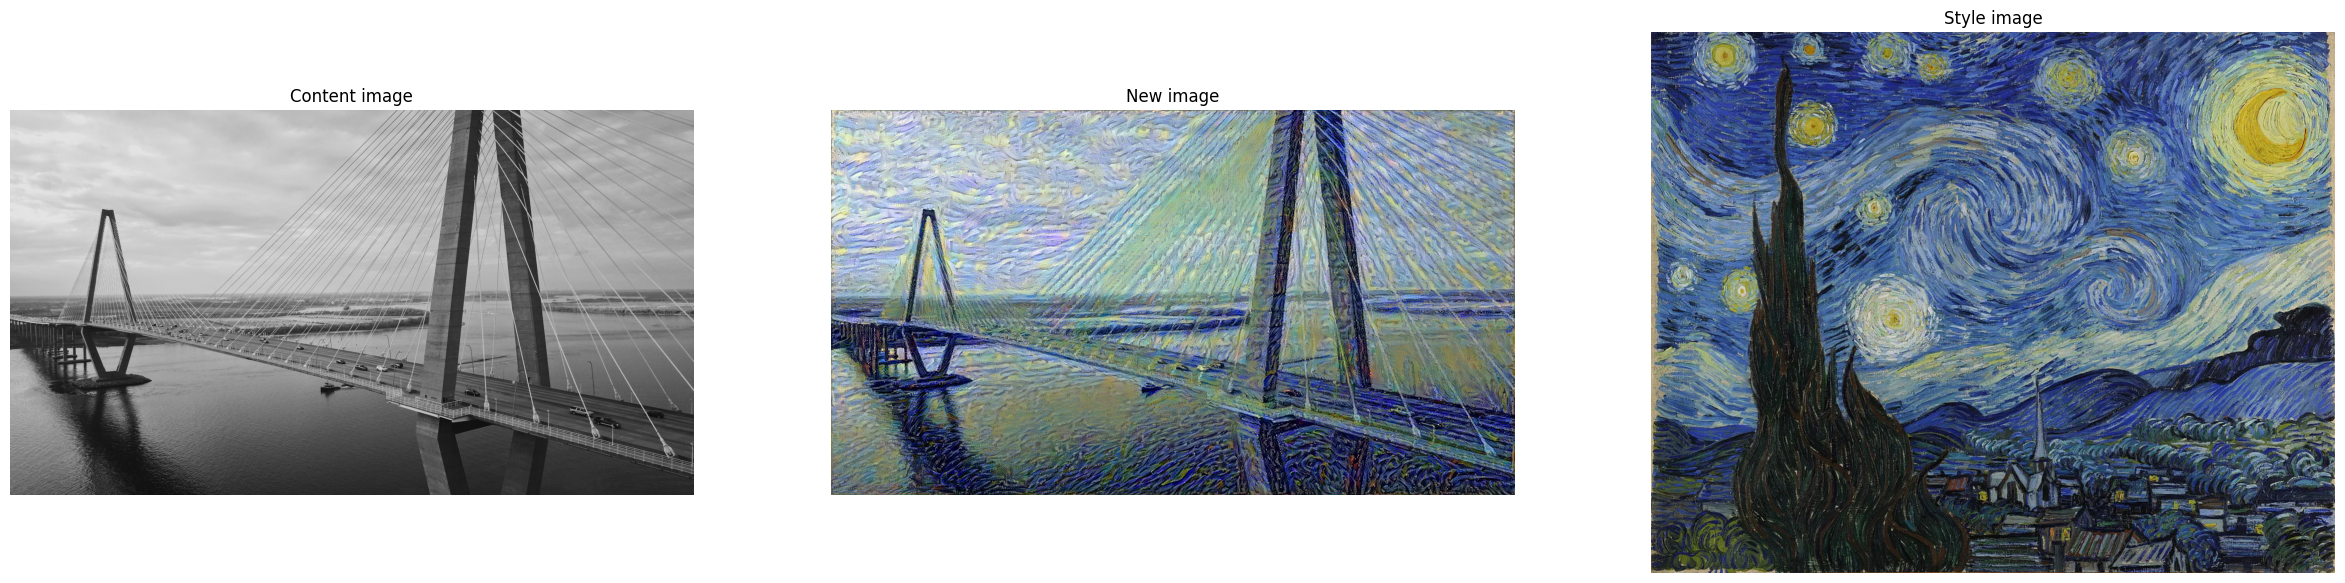

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,8))
ax1.axis('off')
ax1.imshow(tf.squeeze(content_image_1, axis = 0))
ax1.set_title('Content image')
ax2.axis('off')
ax2.imshow(tf.squeeze(new_image, axis = 0))
ax2.set_title('New image')
ax3.axis('off')
ax3.imshow(tf.squeeze(style_image, axis = 0))
ax3.set_title('Style image');

In [ ]:
image_data_array = new_image[0].numpy()

In [ ]:
image_data_array_uint8 = (image_data_array * 255).astype(np.uint8)
save_path = "/content/Generated_img.jpg"
cv2.imwrite(save_path, cv2.cvtColor(image_data_array_uint8, cv2.COLOR_RGB2BGR))


True

In [ ]:
# The new is generated name "Generated_img"